In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("husl", 10)
import missingno as msno

from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import DataConversionWarning
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from fractions import Fraction
from string import ascii_letters

def frac_to_float(frac):
    try:
        if isinstance(frac, float):
            return frac
        if frac == "1 / 200s":
            frac = "1/200"
        return float(sum(Fraction(s.rstrip(ascii_letters)) for s in frac.split()))
    except:
        print(frac)

In [ ]:
"""
Total # of unique image IDs: 12197
Total # of unique image IDs with colors: 12185           Maybe drop images without colors?
Total # of unique image IDs with keywords: 12197
"""

In [45]:
train = pd.read_csv("data/train.csv")
train_colors = pd.read_csv("data/train_colors.csv")
train_keywords = pd.read_csv("data/train_keywords.csv")

outlier_ids = train[train["stats_downloads"] > 300000]["image_id"]

In [46]:
train_downloads = train[["image_id", "stats_downloads"]]
colors_labeled = train_colors.merge(train_downloads, how="inner", on="image_id")
colors_labeled = colors_labeled[~colors_labeled["image_id"].isin(outlier_ids)]
words_labeled = train_keywords.merge(train_downloads, how="inner", on="image_id")
words_labeled = words_labeled[~words_labeled["image_id"].isin(outlier_ids)]
colors_labeled

,image_id,R,G,B,image_hex,keyword,pixel_coverage,color_score,stats_downloads
0,34d72beca9,69,112,154,45709A,steelblue,0.130,0.093,3082
1,34d72beca9,184,185,185,B8B9B9,silver,0.052,0.111,3082
2,34d72beca9,122,122,123,7A7A7B,gray,0.124,0.071,3082
3,34d72beca9,54,95,136,365F88,darkslateblue,0.035,0.069,3082
4,34d72beca9,172,188,206,ACBCCE,lightsteelblue,0.004,0.021,3082
...,...,...,...,...,...,...,...,...,...
119886,e7fd9086d1,80,81,88,505158,darkslategray,0.004,0.004,12353
119887,e7fd9086d1,51,52,67,333443,darkslategray,0.004,0.004,12353
119888,e7fd9086d1,109,111,119,6D6F77,dimgray,0.000,0.000,12353
119889,e7fd9086d1,36,34,40,242228,darkslategray,0.000,0.000,12353


In [49]:
words_labeled

,image_id,image_classification,classification_keyword,confidence_value,stats_downloads
0,d0d041755d,Predicted,grove,99.077,1320
1,d0d041755d,Predicted,compass,26.864,1320
2,d0d041755d,Predicted,field,94.294,1320
3,d0d041755d,Predicted,jar,43.129,1320
4,d0d041755d,Predicted,flower,81.635,1320
...,...,...,...,...,...
1291027,8aa2cc9225,Predicted,hotel,33.519,1215
1291028,8aa2cc9225,Predicted,resort,28.783,1215
1291029,8aa2cc9225,Predicted,light,52.601,1215
1291030,8aa2cc9225,Predicted,light fixture,33.200,1215


In [50]:
colors = []
counts = []
avg_downloads = []
for group, data in colors_labeled.groupby("keyword"):
    colors.append(group)
    counts.append(len(data))
    avg_downloads.append(data["stats_downloads"].mean())
color_downloads = pd.DataFrame({"color": colors, "count": counts, "avg_downloads": avg_downloads})

In [59]:
color_downloads.sort_values(["count", "avg_downloads"], ascending=False, inplace=True)
color_downloads.reset_index(drop=True, inplace=True)
color_downloads

,color,count,avg_downloads
0,darkslategray,17879,9164.268
1,dimgray,10155,8595.077
2,darkolivegreen,8627,8066.791
3,black,7944,7711.406
4,gray,7000,8248.765
...,...,...,...
134,lime,2,3357.000
135,lightyellow,1,12267.000
136,darkgrey,1,6971.000
137,grey,1,4315.000


In [24]:
words_labeled

,image_id,image_classification,classification_keyword,confidence_value,stats_downloads
0,d0d041755d,Predicted,grove,99.077,1320
1,d0d041755d,Predicted,compass,26.864,1320
2,d0d041755d,Predicted,field,94.294,1320
3,d0d041755d,Predicted,jar,43.129,1320
4,d0d041755d,Predicted,flower,81.635,1320
...,...,...,...,...,...
1291027,8aa2cc9225,Predicted,hotel,33.519,1215
1291028,8aa2cc9225,Predicted,resort,28.783,1215
1291029,8aa2cc9225,Predicted,light,52.601,1215
1291030,8aa2cc9225,Predicted,light fixture,33.200,1215


In [13]:
groups_colors = list(train_colors.groupby("image_id"))
groups_words = list(train_keywords.groupby("image_id"))

In [15]:
len(groups_words)

12197

In [4]:
train_keywords

,image_id,image_classification,classification_keyword,confidence_value
0,d0d041755d,Predicted,grove,99.077
1,d0d041755d,Predicted,compass,26.864
2,d0d041755d,Predicted,field,94.294
3,d0d041755d,Predicted,jar,43.129
4,d0d041755d,Predicted,flower,81.635
...,...,...,...,...
1291027,8aa2cc9225,Predicted,hotel,33.519
1291028,8aa2cc9225,Predicted,resort,28.783
1291029,8aa2cc9225,Predicted,light,52.601
1291030,8aa2cc9225,Predicted,light fixture,33.200


<Axes: xlabel='color_score', ylabel='stats_downloads'>

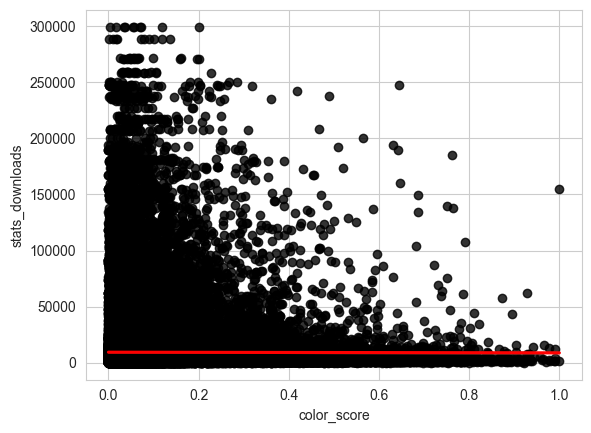

In [64]:
sns.regplot(x="color_score", y="stats_downloads", data=colors_labeled, scatter_kws={"color": "black"}, line_kws={"color": "red"})

<Axes: xlabel='pixel_coverage', ylabel='stats_downloads'>

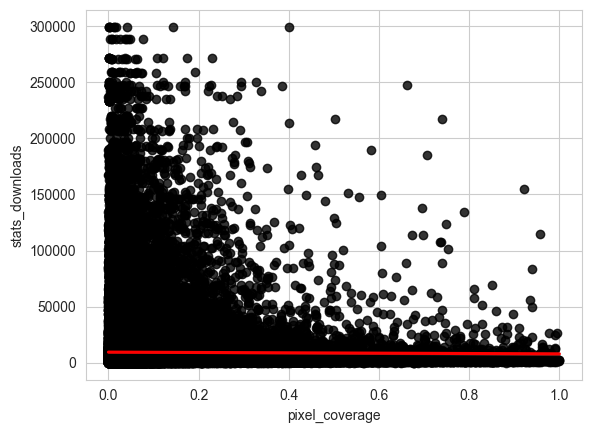

In [65]:
sns.regplot(x="pixel_coverage", y="stats_downloads", data=colors_labeled, scatter_kws={"color": "black"}, line_kws={"color": "red"})

<Axes: ylabel='avg_downloads'>

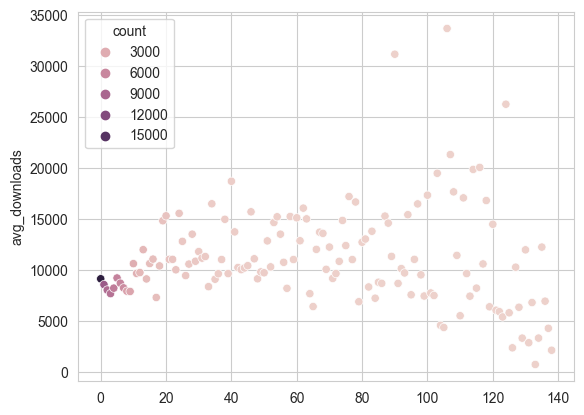

In [63]:
# sns.regplot(x=color_downloads.index, y="avg_downloads", data=color_downloads, 
#             color="count",
#             scatter_kws={"color": "black"}, 
#             line_kws={"color": "red"}
#             )

sns.scatterplot(x=color_downloads.index, y="avg_downloads", data=color_downloads, 
            hue="count",
            )